In [132]:
import musclebeachtools_hlab as mbt
import neuraltoolkit as ntk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import numpy.linalg as la
import numpy.ma as ma
import sys
from datetime import date
import time
import glob, os
from samb_work import dimtools as dimt
from samb_work import video_tools as vt
import pickle
import pandas as pd
import scipy
import scipy.cluster.hierarchy as spc
from statsmodels.sandbox.tsa.movstat import movmean
import json
import matplotlib as mpl

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

if sys.platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'
    
pth = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/figure_1/'

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [18]:
# #                        Colors
# # sleep_clrs = {
# #         'active': '#34f6ee', 
# #         'NREM': '#5560e1',
# #         'REM': '#c555e1'
# #        }

# sleep_clrs = {
#         'active': '#b1b5f3', 
#         'NREM': '#ffb1c3',
#         'REM': '#ffdb8c'
#        }

# # sleep_clrs = {
# #         'active': 'black', 
# #         'NREM': 'black',
# #         'REM': 'black'
# #        }

# sleep_nums = {
#     1: 'active',
#     2: 'NREM',
#     3: 'REM'
#     }

# reg_clrs ={
#     'VISp': '#4985ca',
#     'RSP': '#59b250',
#     'ACAd': '#86368e',
#     'CA1': '#d9b300'
#     }

ld_clrs = {
    'light': '#f9ffcf',
    'dark': '#5C5C5C'
}

dump = 0

In [133]:
#                        Colors

with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
    
with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/reg_colors.json') as json_file:
    reg_clrs = json.load(json_file)

with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/sleep_colors.json') as json_file:
    sleep_clrs = json.load(json_file)
    
dump = 0

In [3]:
def zscore(data):
    return (data - np.mean(data))/np.std(data)

def return_sleep_scores(f):
    sleep_states = np.zeros((2,0))
    sleeps = np.load(f)
    timestamps = (np.nonzero(np.diff(sleeps))[0]+1)*4
    time_ind = (timestamps/4)-1
    states = sleeps[time_ind.astype(int)]
#     timestamps = timestamps+(3600*idx)
    s = np.array(states)
    t = np.stack((timestamps,s))
    sleep_states = np.concatenate((sleep_states,t), axis =1)
#     last = idx
    
    start_time = np.append([0],sleep_states[0,:-1])
    stop_time = sleep_states[0,:]
    sleepstate = sleep_states[1,:]
    
    sleepstate[sleepstate==5] = 1

    sleepdf = pd.DataFrame({'start_time': start_time,'stop_time': stop_time,'sleepstate': sleepstate})
    return(sleepdf)

In [4]:
# Set up the time series of firing rates by region across 24h with sleep wake information

binsz = 1
reclen = 24 * 3600 * binsz

regions = ['ACAd','RSP','CA1','VISp']

# Load, bin, average across population, and normalize spiking data
spk1_file = f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF81/0304/0_12/CAF81_0304_0_12_singleunits.npy'
spk2_file = f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF81/0304/12_24/CAF81_0304_12-24_singleunits.npy'

spk1 = np.load(spk1_file,allow_pickle=True)
spk2 = np.load(spk2_file,allow_pickle=True)

rsurates = []
fsrates = []

reg_names ={
    'VISp': 'V1',
    'RSP': 'RSC',
    'ACAd': 'ACC',
    'CA1': 'CA1'
    }

for roi in regions:
    spk1_reg = dimt.nrnlist_by_region(spk1,reg_names[roi])
    spk2_reg = dimt.nrnlist_by_region(spk2,reg_names[roi])
    spk1_rsu = dimt.nrnlist_by_celltype(spk1_reg,'RSU')
    spk2_rsu = dimt.nrnlist_by_celltype(spk2_reg,'RSU')
    spk1_fs = dimt.nrnlist_by_celltype(spk1_reg,'FS')
    spk2_fs = dimt.nrnlist_by_celltype(spk2_reg,'FS')
    rsurates_1 = np.mean(dimt.bin_spikes(spk1_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates_2 = np.mean(dimt.bin_spikes(spk2_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates.append(np.hstack([zscore(rsurates_1),zscore(rsurates_2)]))
    fsrates_1 = np.mean(dimt.bin_spikes(spk1_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates_2 = np.mean(dimt.bin_spikes(spk2_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates.append(np.hstack([zscore(fsrates_1),zscore(fsrates_2)]))
    
# Load and concatenate sleep scores from two consecutive 12 hour blocks

sleepfiles = np.sort(glob.glob(f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF81/0304/*/*sleep.npy'))

sleepdf_b1 = return_sleep_scores(sleepfiles[0])
sleepdf_b2 = return_sleep_scores(sleepfiles[1])

sleepdf_b2.start_time = sleepdf_b2.start_time + sleepdf_b1.stop_time.iloc[-1]
sleepdf_b2.stop_time = sleepdf_b2.stop_time + sleepdf_b1.stop_time.iloc[-1]

sleepdf = pd.concat([sleepdf_b1,sleepdf_b2])

# Determine recording and video start times

with open(f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF81/0304/0_12/files.txt') as f:
    first_line = f.readline()
    recstart = first_line.split('int16_')[-1].split('.bin')[0]
recstart_dt = vt.dtify(recstart)

firstvid = np.sort(glob.glob(f'/{basedir}/HlabShare/Sleep_Scoring/CAF00081/03042021/video/*.h5'))[0].split('/')[-1]
vidstart = vt.vidfile_to_datetime(firstvid)
vidstart_dt = vt.dtify(vidstart)

# Load and resample locomotion data

locofiles = np.sort(glob.glob(f'/{basedir}/HlabShare/Sleep_Scoring/CAF00081/03042021/video/*tmove.npy'))

loco = np.array([])
for f in locofiles:
    loc = np.load(f)[0,:]
    fps = loc.shape[0]/3600
    loco_rs = np.mean(np.reshape(loc,[int(loc.shape[0]/int(fps * binsz)),int(fps * binsz)]),axis=1)
    loco = np.concatenate([loco,loco_rs])

/var/folders/83/z8cb58r94nx05wf2wrh4d8x80000gn/T/ipykernel_81949/327542999.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  darktime_bins = np.int(darktime_sec/binsz)


slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)


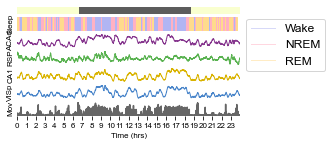

In [19]:
#Plotting step
fig,ax = plt.subplots(nrows=7,ncols=1,figsize=(4,2),
    gridspec_kw={'height_ratios': [1,2,2,2,2,2,2]},sharex=True)

#L/D Plotting
darktime = vt.dtify(recstart.split('_')[0] + '_19-30-00') #hard coded
darktime_sec = (darktime - recstart_dt).seconds
darktime_bins = np.int(darktime_sec/binsz)

category_names = ['Light', 'Dark', 'Light']
category_colors = np.array([ld_clrs['light'],ld_clrs['dark'],ld_clrs['light']])
lefts = np.array([0,darktime_bins, darktime_bins + (12*3600*binsz)])
widths = np.array([darktime_bins,(12*3600*binsz),reclen-(darktime_bins+(12*3600*binsz))])

ax[0].invert_yaxis()
ax[0].xaxis.set_visible(False)

for c, (colname, color) in enumerate(zip(category_names, category_colors)):
    ax[0].barh([''], widths[c], left=lefts[c], height=0.5,
                    label=colname, color=color)
ax[0].axis('off')
#ax[0].text(darktime_bins,1,'test')
#End L/D Plotting

for r,roi in enumerate(regions):
    frsma = movmean(rsurates[r][:reclen],windowsize=600)
    ax[r+2].plot(frsma, color = reg_clrs[roi],label='Simple Moving Average', lw = 1)
    ax[r+2].set_ylabel(f'{roi}',fontsize=8)

ax[6].plot(loco[:reclen],alpha=0.6,color='black')
ax[6].set_ylabel('Mov',fontsize=8)

#sleep plotting
sleepdf_reclen = sleepdf[sleepdf.stop_time<(reclen/binsz)]

for c, statename in enumerate(np.unique(sleepdf_reclen.sleepstate)):
    
    state = sleepdf_reclen[sleepdf_reclen.sleepstate==statename]
    
    for j in range(len(state)):
        
        ax[1].axvspan(xmin=state["start_time"].iloc[j], xmax=state["stop_time"].iloc[j],
                      color=sleep_clrs[sleep_nums[statename]], alpha=1)

custom_lines = [Line2D([0], [0], color=sleep_clrs['active'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['NREM'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['REM'], alpha=0.5, lw=1)]

ax[1].legend(custom_lines,['Wake','NREM','REM'],bbox_to_anchor=(1,1.3),fontsize=12)

ax[1].set_ylabel('Sleep',fontsize=8)

for i in np.arange(1,7):
    ax[i].set_yticks([])

for i in np.arange(1,6):
    ax[i].xaxis.set_visible(False)
    
for i in np.arange(2,7):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

ax[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

minbwtix = 60
xtix = np.arange(0,reclen,60*minbwtix/binsz)
xtixlabs = (xtix*binsz/3600).astype(int)

ax[6].set_xticks(xtix)
ax[6].set_xticklabels(xtixlabs,fontsize=8)
ax[6].set_xlabel('Time (hrs)',fontsize=8)

plt.xlim(0,reclen)

if dump:
    filename = '_longterm_recording_fig.pdf'
    plt.savefig(pth+today+filename, bbox_inches='tight')
else:
    pass

plt.show()

In [22]:
neuraldir = f'/{basedir}/bs006r/CAF00088/CAF00088_2021-05-20_16-34-39/'
rawfile = 'Headstages_256_Channels_int16_2021-05-20_16-34-40.bin'

fs = 25000

number_of_channels = np.int(rawfile.split('_')[1])
hstype = ['APT_PCB', 'APT_PCB', 'APT_PCB', 'APT_PCB']   # Channel map
# hstype = ['linear', 'linear', 'linear', 'linear']   # Channel map
nprobes = np.int(number_of_channels/64)
probechans = 64  #  number of channels per probe (symmetric)

t, dgc = ntk.load_raw_binary_gain_chmap_nsec(
        name=neuraldir + rawfile,
        number_of_channels=number_of_channels,
        hstype=hstype,
        fs=fs,
        nsec=5,
        nprobes=nprobes,
)

bdgc = ntk.butter_bandpass(dgc, 150, 3000, 25000, 3)

/var/folders/83/z8cb58r94nx05wf2wrh4d8x80000gn/T/ipykernel_81949/3987753468.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number_of_channels = np.int(rawfile.split('_')[1])
/var/folders/83/z8cb58r94nx05wf2wrh4d8x80000gn/T/ipykernel_81949/3987753468.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to re

['APT_PCB', 'APT_PCB', 'APT_PCB', 'APT_PCB']
['APT_PCB', 'APT_PCB', 'APT_PCB', 'APT_PCB']
Number of probes 4
Assuming all probes have same number of channels
Number of channels per probe 64
APT_PCB
APT_PCB
APT_PCB
APT_PCB


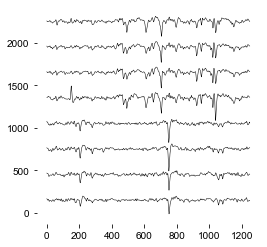

In [112]:
t_on = 1 # time to start plotting
window = 50 # time in msec to show in the plot

# decent windows: 1.4, 2.8, 3.4
# -----------------------------
t_on = int(t_on * fs)
t_off = t_on + ( 25 * window)

# chans  1-12, 100, 192, 148 ....     32, 33, 34, 35,
#          
chstoplot = np.array([
    0,1,2,3,
    112, 113, 114, 115
])

# chstoplot = np.arange(0,256)


fig, ax = plt.subplots(figsize=[4,4])

maxvolt = 150
# maxvolt = 50
for i,ch in enumerate(chstoplot):
    ypos = (i * maxvolt * 2) + maxvolt
    ax.plot(bdgc[ch, t_on:t_off] + ypos,color='black',linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)


voltbwrows = int(((1 * maxvolt * 2) + maxvolt) - ((0 * maxvolt * 2) + maxvolt))

if dump:
    filename = f'_rawdatafig_{int(window/fs*1e3)}ms_{voltbwrows}uVbwrows.pdf'
    plt.savefig(pth+today+filename)
else:
    pass

plt.show()

In [114]:
headdir = f'/{basedir}/HlabShare/SamB/APPdata/'
# datafile_wt = 'wt_mod_backup_8321.npy'
# datafile_app = 'app_mod_backup_8321.npy'

n_wt_all = np.load(headdir+'wt_mod.npy', allow_pickle=True)
n_app_all = np.load(headdir+'app_mod.npy', allow_pickle=True)

n_wt = dimt.nrnlist_by_quality(n_wt_all,[1])
n_app = dimt.nrnlist_by_quality(n_app_all,[1])

nrns = n_wt + n_app

In [115]:
import matplotlib.cm as cm
import matplotlib.colors as clr
colarray = np.tile(np.linspace(0,1,10),np.ceil(len(nrns)/10).astype('int'))[:len(nrns)]
col = plt.cm.viridis(colarray)

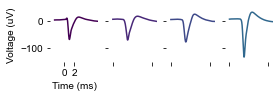

In [123]:
xtickpos = np.array([50,100])
xticklabs = (xtickpos/25000 * 1e3).astype(int) - 2

usethese = [18, 314, 316, 325]

nrns2 = [nrns[i] for i in usethese]

fign, axn = plt.subplots(ncols = 4, nrows = 1, figsize = [4,1])

for i,n in enumerate(nrns2):
    
    wfdat = n.waveforms
    axn[i].plot(wfdat,c=col[i])
    axn[i].set_ylim(-150,50)
    
    midpt = np.argmin(wfdat)
    axn[i].set_xlim(midpt-100,midpt+150)
    
    if i == 0:
        axn[i].set_xticks(xtickpos)
        axn[i].set_xticklabels(xticklabs)

        axn[i].set_ylabel('Voltage (uV)')
        axn[i].set_xlabel('Time (ms)')
    else:

        axn[i].set_xticklabels('')
        axn[i].set_yticklabels('')
        axn[i].set_ylabel('')
        axn[i].set_xlabel('')
        

sns.despine(left = True, bottom = True)

if dump:
    plt.savefig(pth+today+'_meanWFs_'+'.pdf')
else:
    pass

#     plt.show()

In [125]:
nrnlist = np.array(list(n_wt_all) + list(n_app_all))
goodcells = [92, 430, 504, 544, 632]

n_lines = len(goodcells)
col = np.arange(1, n_lines + 1)

norm = mpl.colors.Normalize(vmin=col.min(), vmax=col.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

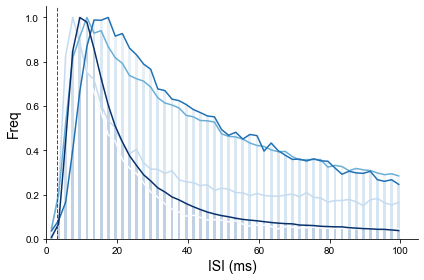

In [126]:
# '#5DADE2'

for i,c in enumerate(goodcells):
# i = 544
    cell = nrnlist[c]
    time_s = cell.spike_time/cell.fs
    start = cell.start_time
    end = cell.end_time
    idx = np.where(np.logical_and(time_s >= start, time_s <= end))[0]
    ISI = np.diff(time_s[idx])
    edges = np.linspace(0, 0.1, 51)
    hist_isi = np.histogram(ISI, edges)
    plt.bar(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1),alpha=0.1)
    plt.plot(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1))
#     plt.bar(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1),alpha=0.2)
#     plt.plot(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1))

plt.axvline(x=3, color='r', linestyle='dashed', linewidth=1) #dashed line at 3 ms
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('ISI (ms)',fontsize=14)
plt.ylabel('Freq',fontsize=14)

plt.tight_layout()
sns.despine()

if dump:
    filename = f'ISIs_representative.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [127]:
epochstatscsv = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/A_preprocessing/epoch_stats_100ms.csv'

epochstats = pd.read_csv(epochstatscsv)
epochstats['sleepoch'] = ['_'.join(i) for i in zip(epochstats['date'].astype(str), epochstats['recepoch'].astype(str), epochstats['epoch'].astype(str))]

epochagg = epochstats[['geno','state','sleepoch','animal','epoch_len']].groupby(['geno','state','sleepoch']).max().reset_index()
epochagg = epochagg.sort_values(['geno','state'], ascending = [False,True])

ind = np.unique(epochagg.animal, return_index=True)[1]
animallist = [epochagg.animal.iloc[i] for i in sorted(ind)]

time_in_state = np.zeros([8,3])
for a, animal in enumerate(animallist):
    for s,state in enumerate(['active','nrem','rem']):
        time_in_state[a,s] = np.sum(epochagg[(epochagg.animal==animal)&(epochagg.state==state)].epoch_len)
        
time_in_state_mean_wt = np.mean(time_in_state[:4,:],axis=0)
time_in_state_mean_app = np.mean(time_in_state[4:,:],axis=0)

perc_in_state = (time_in_state.T/np.sum(time_in_state,axis=1)).T
perc_in_state_mean_wt = np.mean(perc_in_state[:4,:],axis=0)
perc_in_state_mean_app = np.mean(perc_in_state[4:,:],axis=0)


In [171]:
epochstatscsv = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/A_preprocessing/epoch_stats_100ms.csv'
epochstats = pd.read_csv(epochstatscsv)
epochstats['adr_id'] = epochstats['animal'] + '_' + epochstats['date'].astype(str) + '_' + epochstats['recepoch']

selected_recepochs = ['CAF69_1230_12_24', 'CAF71_103_0_12', 'CAF73_120_4_15', 'CAF74_125_48_60',
'CAF75_125_53_64', 'CAF77_202_12_24', 'CAF81_304_12_24', 'CAF82_304_12_24']

epochstats_1rec = epochstats[epochstats.adr_id.isin(selected_recepochs)]
epoch_meanfr = epochstats_1rec[['epoch','fr_mean','state','geno','region']]
epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']
epoch_meanfr_agg = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).mean('fr_mean')
epoch_meanfr_agg = epoch_meanfr_agg.drop('epoch',axis=1)
epoch_meanfr_agg['n_epoch'] = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).count()['epoch']

/var/folders/83/z8cb58r94nx05wf2wrh4d8x80000gn/T/ipykernel_81949/2851148498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
/var/folders/83/z8cb58r94nx05wf2wrh4d8x80000gn/T/ipykernel_81949/2851148498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']


In [210]:
dump = 1

0
1
2


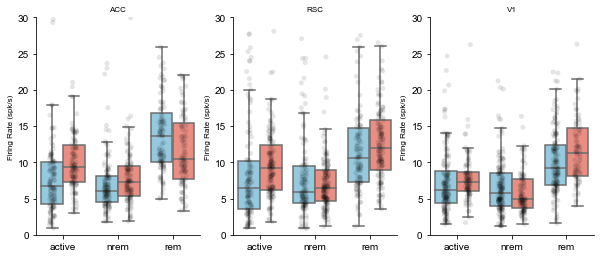

In [212]:
figf, axf = plt.subplots(ncols = 3, nrows = 1, figsize = [10,4])

regions = np.unique(epoch_meanfr_agg.region)

for i, roi in enumerate(regions):
    print(i)
    sns.boxplot( x='state', y='fr_mean', hue='geno', data = epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
                   palette = [geno_clrs['WT'],geno_clrs['APP']], fliersize=0, ax = axf[i])
    
    sns.stripplot( x='state', y='fr_mean', hue='geno', data=epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
               palette = ['black', 'black'], dodge=True, alpha = 0.1, ax = axf[i], edgecolor = ['white','white'])
    
    axf[i].set_title(str(roi).upper(),fontsize=8)
    axf[i].set_ylabel('Firing Rate (spk/s)',fontsize=8)
    axf[i].set_xlabel('')

    axf[i].set_ylim(0,30)
    sns.despine()
    axf[i].legend([],[], frameon=False)
    
if dump:
    filename = f'_meanfr_by_state_boxplot.pdf'
    plt.savefig(pth+today+filename)
else:
    pass
plt.show()